In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

### Read in samples for origin ARS315, set up the annotation of the nucleosome areas

## Wildtype

In [8]:
load_dir =  "ARS315"


In [93]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS315_starting_LexA.txt")

#replicate 2

#rep2_raw = np.genfromtxt("ARS315/mat_Megalodon_repII_ARS315_starting_LexA.txt", delimiter = "\t")
#rep2_raw.shape #1236, 1238 
#np.where(np.isnan(wt_rep2[:, 1])) #smallest value is 697
#select the first 697 rows and save as a separate file
#np.savetxt("ARS315/mat_Megalodon_repII_ARS315_cleaned.txt", rep2_raw[:697,:1236])

wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS315_cleaned.txt")

#feature annotation
anno = pd.read_csv(load_dir + "/Features from ARS315_starting_LexA  (31 .. 1277).txt", sep  = "\t", 
                          header = None, index_col = 0)
anno.columns = ["position", "length"]
anno.index = anno.index.astype("string")
anno.index = anno.index.str.strip()

anno["pos_start"] = anno.position.str.split(".").str[0].astype(int) -1
anno["pos_stop"] = anno.position.str.split(".").str[2].astype(int) -1

In [26]:
anno

,position,length,pos_start,pos_stop
0,,,,
NS-2,39..185,147,38,184
L-1,186..195,10,185,194
NS-1,196..342,147,195,341
ARS315,465..710,246,464,709
NS+1,590..736,147,589,735
L+1,737..771,35,736,770
NS+2,772..918,147,771,917
VHS1Prom,919..1117,199,918,1116
NS+3,1118..1190,73,1117,1189


In [27]:
wt_rep2.shape[1] == wt_rep3.shape[1]

True

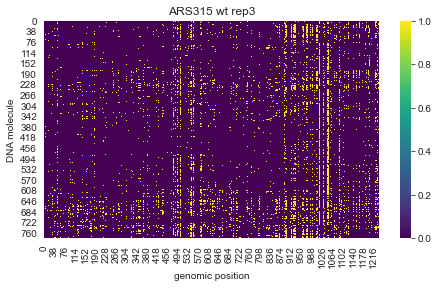

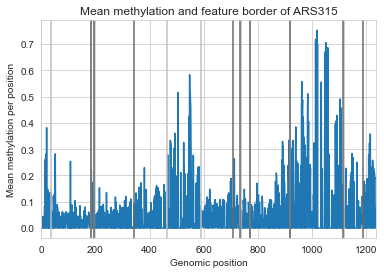

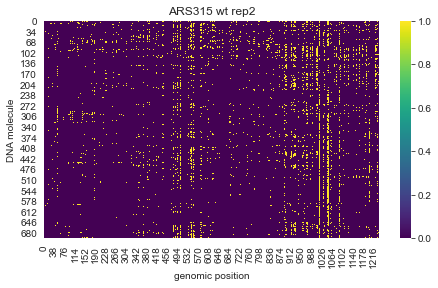

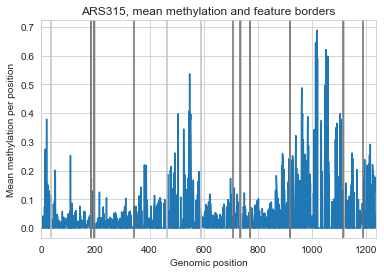

In [51]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep2")
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title(load_dir + ", mean methylation and feature borders")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

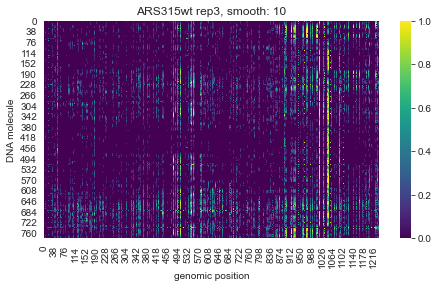

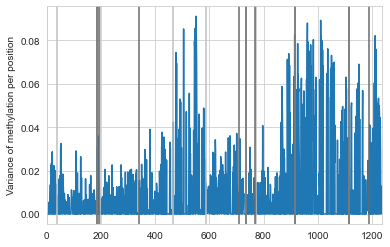

In [52]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [53]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       4.77346278])

In [54]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = math.e if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

<AxesSubplot:title={'center':'ARS315 wt rep3, entropy per position'}, ylabel='entropy'>

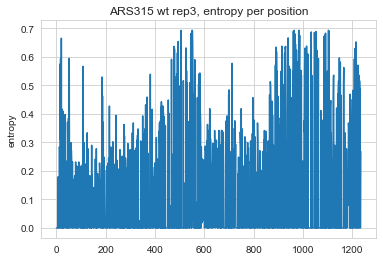

In [55]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [56]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.6930649955339707, 626)

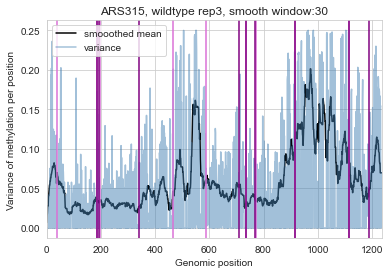

In [57]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  ", wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

(780, 1236)


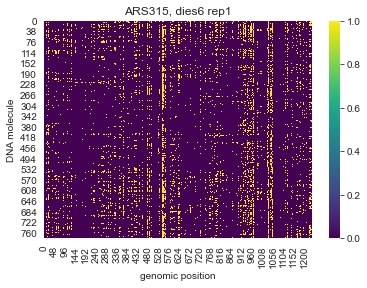

(780, 1236)


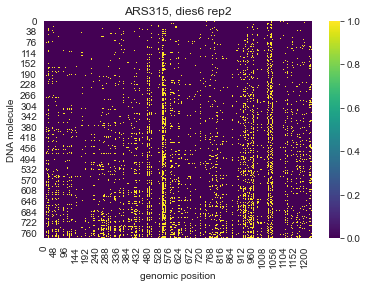

In [60]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS315_starting_LexA.txt")
print(dies6_rep1.shape)

sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS315_REP2_780READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape)

sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

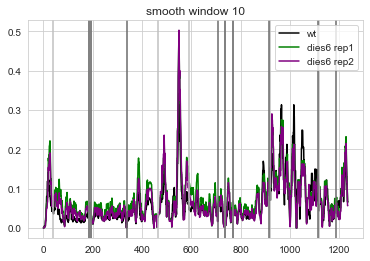

(125781.5, 4.815808852239222e-91)

In [61]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [62]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=23727.0, pvalue=4.71686980406011e-57)

## Load data for mutant disw2

(780, 1236)


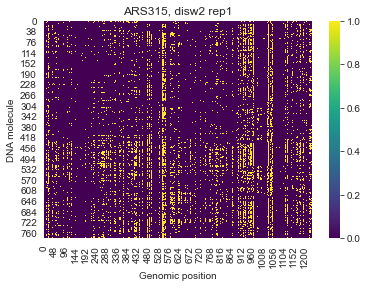

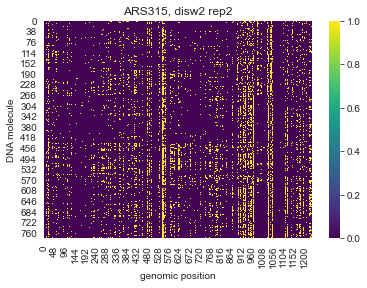

In [64]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS315_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape)

sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()

disw2_rep2 = np.genfromtxt(load_dir + "/ARS315_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
disw2_rep2.shape

sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

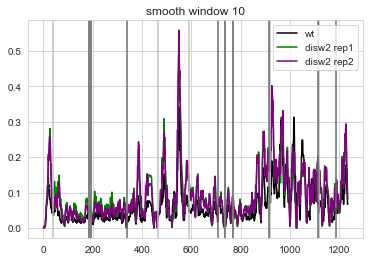

In [65]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [66]:
# calculate the mean over all molecules and smooth with window size "smooth"

disw2_rep1_smooth_mean = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
disw2_rep2_smooth_mean = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((means, 
                        disw2_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        disw2_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                        axis = 0)

w, p = wilcoxon(disw2_rep1.mean(axis = 0),
                disw2_rep2.mean(axis = 0), alternative = "two-sided")
w,p

(79017.5, 0.00046746413185167255)

## Condense segment information for statistical testing of methylation per feature window

In [67]:
segments = anno.drop(columns = "position")

#list comprehension to catch the smoothed methylation values per sample in a cell per column
array_list = [wt_rep3_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_rep3_smooth_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_rep1_smooth_mean"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_rep2_smooth_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [disw2_rep1_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_rep1_smooth_mean"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_smooth_mean[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_rep2_smooth_mean"] = pd.Series(array_list, index = segments.index)

In [68]:
#this chunk doesn't work yet, it should catch the values per sample automatically from a list of samples
#samples = [ARS305_wt_smooth_mean, ARS305_dies6_rep1_smooth_mean, ARS305_dies6_rep2_smooth_mean]

#ARS305_segments = ARS305_anno.drop(columns = "position")

#for sample in samples:
#    temp_array_list = [samples[ARS305_segments.loc[index, "pos_start"]:ARS305_segments.loc[index, "pos_stop"]] for
#                  index in ARS305_segments.index]
#    #print(temp_array_list)
#    ARS305_segments[sample] = pd.Series(temp_array_list, index = ARS305_segments.index)   

In [69]:
#ARS305_segments.drop(index = ["L+2", "L-1"], inplace = True)

segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_rep3_smooth_mean"], 
                                           segments.loc[index,"dies6_rep1_smooth_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_rep3_smooth_mean"], 
                                           segments.loc[index,"dies6_rep2_smooth_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_rep3_smooth_mean"], 
                                           segments.loc[index,"disw2_rep1_smooth_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_rep3_smooth_mean"], 
                                           segments.loc[index,"disw2_rep2_smooth_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

In [70]:
print("           Overview of p-values for different mutants")
print("           Smoothing window: " + str(smooth_window))
segments.drop(segments.columns[3:8], axis =1)

           Overview of p-values for different mutants
           Smoothing window: 10


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,38,184,4.524586e-25,2.845045e-21,1.018506e-24,2.759620e-19
L-1,10,185,194,7.812500e-03,3.906250e-03,3.593750e-01,7.421875e-02
NS-1,147,195,341,1.120375e-25,3.997689e-20,1.042569e-25,1.042762e-25
ARS315,246,464,709,2.190483e-29,1.260225e-10,5.815533e-33,1.497251e-35
NS+1,147,589,735,1.715509e-21,8.088670e-02,4.682235e-23,4.416059e-23
L+1,35,736,770,1.242033e-05,1.598019e-03,9.806886e-06,2.253393e-06
NS+2,147,771,917,1.382241e-12,1.124825e-02,1.254257e-23,1.235792e-24
VHS1Prom,199,918,1116,9.112024e-01,1.083742e-02,8.382448e-06,1.948895e-07
NS+3,73,1117,1189,1.389381e-06,5.314688e-01,3.627258e-13,2.729092e-13


In [71]:
#Regions significant for disw2:
pvalue = 2.5e-2

test = segments.drop(segments.columns[3:8], axis =1)

print("       Which sites have a different mean methylation for the disw2 mutatant?")
test.loc[(test["p_value_disw2_rep1"] < pvalue) & 
         (test["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation for the disw2 mutatant?


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,38,184,4.524586e-25,2.845045e-21,1.018506e-24,2.759620e-19
NS-1,147,195,341,1.120375e-25,3.997689e-20,1.042569e-25,1.042762e-25
ARS315,246,464,709,2.190483e-29,1.260225e-10,5.815533e-33,1.497251e-35
NS+1,147,589,735,1.715509e-21,8.088670e-02,4.682235e-23,4.416059e-23
L+1,35,736,770,1.242033e-05,1.598019e-03,9.806886e-06,2.253393e-06
NS+2,147,771,917,1.382241e-12,1.124825e-02,1.254257e-23,1.235792e-24
VHS1Prom,199,918,1116,9.112024e-01,1.083742e-02,8.382448e-06,1.948895e-07
NS+3,73,1117,1189,1.389381e-06,5.314688e-01,3.627258e-13,2.729092e-13


In [72]:
#Regions significant for dies6:
pvalue = 2.5e-2

test = segments.drop(segments.columns[3:8], axis =1)

print("       Which sites have a different mean methylation for the disw2 mutatant?")
test.loc[(test["p_value_dies6_rep1"] < pvalue) & 
         (test["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation for the disw2 mutatant?


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,38,184,4.524586e-25,2.845045e-21,1.018506e-24,2.759620e-19
L-1,10,185,194,7.812500e-03,3.906250e-03,3.593750e-01,7.421875e-02
NS-1,147,195,341,1.120375e-25,3.997689e-20,1.042569e-25,1.042762e-25
ARS315,246,464,709,2.190483e-29,1.260225e-10,5.815533e-33,1.497251e-35
L+1,35,736,770,1.242033e-05,1.598019e-03,9.806886e-06,2.253393e-06
NS+2,147,771,917,1.382241e-12,1.124825e-02,1.254257e-23,1.235792e-24


In [73]:
#Repeat this test for the hypothesis that methylation in one fragment is higher than in wildtype:
test_higher = segments.iloc[:, :8]
test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_rep3_smooth_mean"], 
                                           test_higher.loc[index,"dies6_rep1_smooth_mean"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_rep3_smooth_mean"], 
                                           test_higher.loc[index,"dies6_rep2_smooth_mean"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_rep3_smooth_mean"], 
                                           test_higher.loc[index,"disw2_rep1_smooth_mean"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_rep3_smooth_mean"], 
                                           test_higher.loc[index,"disw2_rep2_smooth_mean"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(segments.columns[3:8], axis =1, inplace = True)

In [74]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,38,184,2.262293e-25,1.422523e-21,5.092531e-25,1.379810e-19
NS-1,147,195,341,5.601876e-26,1.998845e-20,5.212847e-26,5.213812e-26
ARS315,246,464,709,1.095241e-29,6.301126e-11,2.907767e-33,7.486255e-36
L+1,35,736,770,6.210164e-06,7.990096e-04,4.903443e-06,1.126696e-06


In [75]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,38,184,2.262293e-25,1.422523e-21,5.092531e-25,1.379810e-19
NS-1,147,195,341,5.601876e-26,1.998845e-20,5.212847e-26,5.213812e-26
ARS315,246,464,709,1.095241e-29,6.301126e-11,2.907767e-33,7.486255e-36
NS+1,147,589,735,8.577543e-22,4.044335e-02,2.341118e-23,2.208029e-23
L+1,35,736,770,6.210164e-06,7.990096e-04,4.903443e-06,1.126696e-06
NS+2,147,771,917,6.911204e-13,9.943759e-01,6.271283e-24,6.178958e-25
VHS1Prom,199,918,1116,5.443988e-01,9.945813e-01,4.191224e-06,9.744476e-08
NS+3,73,1117,1189,6.946906e-07,2.657344e-01,1.813629e-13,1.364546e-13


### Min-max normalise each experiment and pool replicates

In [76]:
wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

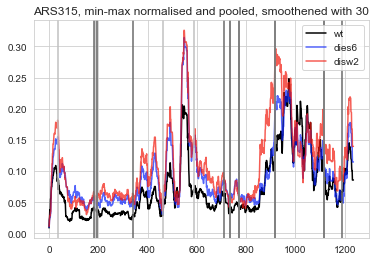

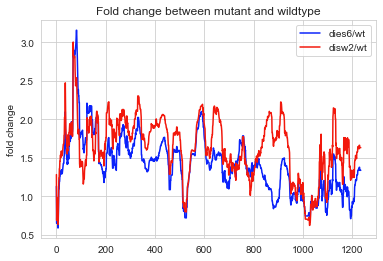

In [88]:
N=30

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title(load_dir +  ", min-max normalised and pooled, smoothened with " + str(N)) #pooled and min-max normalised
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.savefig("ARS315/plots/ARS315_average_methylation.png", dpi = 300)
plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#0a22fa", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "#f2180c",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.savefig("ARS315/plots/ARS315_fold_changes.png", dpi = 300)
plt.show()

### Compare pooled wildtype to mutant replicates, then filter regions

In [80]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [81]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

/Users/karoline.holler/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/karoline.holler/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [82]:
segments

,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,38,184,1.853851e-09,4.145289e-09,2.148975e-06,1.528392e-05
L-1,10,185,194,6.858304e-01,3.452311e-01,8.927384e-01,8.927384e-01
NS-1,147,195,341,5.733164e-06,3.095027e-05,7.708708e-07,2.348983e-06
ARS315,246,464,709,2.230444e-12,1.440024e-08,3.403642e-12,2.436733e-13
NS+1,147,589,735,9.825965e-09,6.995157e-05,2.936869e-08,3.401613e-09
L+1,35,736,770,1.084370e-02,1.762066e-02,1.084370e-02,7.398655e-03
NS+2,147,771,917,3.873262e-05,4.005855e-01,1.310210e-06,1.082831e-07
VHS1Prom,199,918,1116,5.273163e-01,9.820473e-01,1.724249e-01,4.837502e-02
NS+3,73,1117,1189,1.763236e-01,3.175894e-01,3.430852e-02,3.111335e-02


In [83]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,38,184,1.853851e-09,4.145289e-09,2.148975e-06,1.528392e-05
NS-1,147,195,341,5.733164e-06,3.095027e-05,7.708708e-07,2.348983e-06
ARS315,246,464,709,2.230444e-12,1.440024e-08,3.403642e-12,2.436733e-13
NS+1,147,589,735,9.825965e-09,6.995157e-05,2.936869e-08,3.401613e-09
L+1,35,736,770,1.084370e-02,1.762066e-02,1.084370e-02,7.398655e-03


In [84]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,length,pos_start,pos_stop,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
NS-2,147,38,184,1.853851e-09,4.145289e-09,2.148975e-06,1.528392e-05
NS-1,147,195,341,5.733164e-06,3.095027e-05,7.708708e-07,2.348983e-06
ARS315,246,464,709,2.230444e-12,1.440024e-08,3.403642e-12,2.436733e-13
NS+1,147,589,735,9.825965e-09,6.995157e-05,2.936869e-08,3.401613e-09
L+1,35,736,770,1.084370e-02,1.762066e-02,1.084370e-02,7.398655e-03
NS+2,147,771,917,3.873262e-05,4.005855e-01,1.310210e-06,1.082831e-07


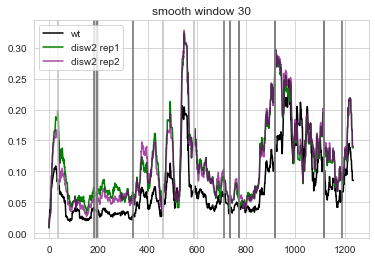

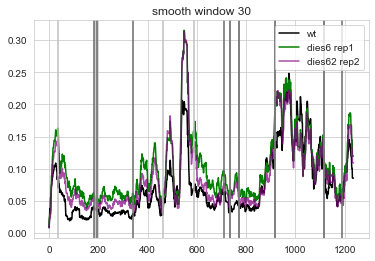

In [85]:
# How does that look over the whole sequence?
smooth_width = 30

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "purple", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "purple", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [90]:
smooth_width
N

30

In [91]:
#Exporting aggregated data for Anna to plot for the manuscript 
#2nd June 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


ARS315_smooth_30 = pd.DataFrame.from_dict(smooth)
ARS315_smooth_30.index = ARS315_smooth_30.index + 1
ARS315_smooth_30.to_csv("ARS315/ARS315_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, 
                                 mode="same")/np.convolve(pooled_wt, 
                                                          np.ones(smooth_width)/smooth_width, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, 
                                 mode="same")/np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode="same")
}

ARS315_FCs = pd.DataFrame.from_dict(FC)
ARS315_FCs.index = ARS315_FCs.index + 1

ARS315_FCs.to_csv("ARS315/ARS315_smoothed_fold_changes_winsize_30.csv")